In [1]:
import ROOT as root
import numpy as np
import random
from timer import Timer

t = Timer()
t.start()

Welcome to JupyROOT 6.26/06


In [2]:
fileName = "data/AnaBarMC_4000.root"
treeName = "T"

f = root.TFile(fileName)
myTree = f.Get(treeName)

myTree.Print()

root.EnableImplicitMT()
d = root.RDataFrame(treeName,fileName)

******************************************************************************
*Tree    :T         : Output Tree                                            *
*Entries :     9579 : Total =      1946028559 bytes  File  Size =   27841792 *
*        :          : Tree compression factor =  70.03                       *
******************************************************************************
*Br    0 :Prim_E    : Prim_E/F                                               *
*Entries :     9579 : Total  Size=      38945 bytes  File Size  =      25516 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.51     *
*............................................................................*
*Br    1 :Prim_X    : Prim_X/F                                               *
*Entries :     9579 : Total  Size=      38945 bytes  File Size  =      26837 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.43     *
*...................................................

In [3]:
triggerCode = '''
int Analyse_Secondaries = 1;
float Theta_min_cut = 2.524;
float ThetaVerticalCut = 3.02;

int MaxPMTNo = 50000;
int MaxPMTHits = 1000;
float Finger_Edep_Max = 10.0;
float AnaBar_Edep_Max = 10.0;
float pedastel_sigma = 2.9;
int Detector_Offset = 2560;
int Detector_PMT_Offset = 2500;
int AnaBar_Offset = 30000;
int AnaBar_PMT_Offset = 0;

int Finger_NPhotons_Max = 250;
int AnaBar_NPhotons_Max = 200;

const int NUMPADDLE = 14;
const int NUMBARS = 14;
const int NUMMODULES = 3;
const int NUMSIDES = 2;
const int NUMLAYERS = 2;

const int NDET = NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS;

int NMaxPMT = 14;

bool getTrigger(int Detector_Nhits, int* Detector_id) {

    bool tophit = false;
    bool bottomhit = false;
    bool fhit = false;
    bool ahit = false;
    bool trigger = false;
    for (int j=0; j<Detector_Nhits; j++) {
        //std::cout << "Detector id = " << Detector_id[j] << std::endl;
        if ((Detector_id[j] == Detector_Offset || Detector_id[j] == Detector_Offset+1) && !tophit) {
            tophit = true;
            //std::cout << "Top hit" << Detector_id[j] << std::endl;
        }
        if ((Detector_id[j] == Detector_Offset+2 || Detector_id[j] == Detector_Offset+3) && !bottomhit) {
            bottomhit = true;
            //std::cout << "Bottom hit" << Detector_id[j] << std::endl;
        }
        for (int ibar=0; ibar<NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS; ibar++){
            if (Detector_id[j] == AnaBar_Offset + ibar) {
                ahit = true;
            }
        }
        if (ahit) {
            fhit = true;
            trigger = true;
        }
    }
    
    return trigger;
}

bool getTrigger2(bool trigger, float fNewTheta) {

    bool trigger2 = false;
    if (fNewTheta > Theta_min_cut) {
        trigger2 = true;
    }
    return trigger2;
}

bool getTrigger3(bool trigger, float fNewTheta) {

    bool trigger3 = false;
    if (fNewTheta > ThetaVerticalCut) {
        trigger3 = true;
    }
    return trigger3;
}

float getMass(int Prim_pdg) {

    float fMass;
    if (Prim_pdg == 11) {
        fMass = 0.511;
    } else {
        if (Prim_pdg == 13) {
            fMass = 105.7;
        } else {
            if (Prim_pdg == 2212) {
                fMass = 938.28;
            } else {
                fMass = 939.65;
            }
        }
    }
    return fMass;
}

float getMomentum(float Prim_E, float fMass) {
    return sqrt(Prim_E*Prim_E - fMass*fMass);
}

float getPx(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Sin(Prim_Th)*TMath::Cos(Prim_Ph);
}

float getPy(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Sin(Prim_Th)*TMath::Sin(Prim_Ph);
}

float getPz(float fMomentum, float Prim_Th, float Prim_Ph) {
    return fMomentum*TMath::Cos(Prim_Th);
}

float getNewTheta(float fMomentum, float fPy) {
    return TMath::ACos(fPy/fMomentum);
}

float getNewPhi(float fMomentum, float fPx, float fPz) {
    float fNewPhi;
    if (fPx < 0.0) {
        fNewPhi = TMath::ATan(fPz/fPx) + TMath::Pi();
    } else {
        if (fPx > 0.0 && fPz < 0.0) {
            fNewPhi = TMath::ATan(fPz/fPx) + TMath::TwoPi();
        } else {
            fNewPhi = TMath::ATan(fPz/fPx);
        }
    }
    return fNewPhi;
}

int getAnaBarMult(bool trigger, int* PMT_Nphotons) {

    int imult = 0;
    float temp;
    TRandom3* fRand = new TRandom3(-1);
    
    for (int icount = 0;icount < NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS;icount++){
        temp = PMT_Nphotons[icount]+fRand->Gaus(0.0,pedastel_sigma);
        if (temp>3.0*pedastel_sigma) {
            imult++;
        }
    }
    
    return imult;
}

std::vector<float> getFingerXVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_x, int Prim_pdg) {

    std::vector<float> v;

    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3) && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_x[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerYVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_y, int Prim_pdg) {
    
    std::vector<float> v;

    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3) && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_y[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerZVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_z, int Prim_pdg) {
    
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3) && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_z[j]);
            }
        }
    }
    return v;
}
std::vector<float> getFingerTVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_t, int Prim_pdg) {
    
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3) && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_t[j]);
            }
        }
    }
    return v;
}

std::vector<float> getAnaBarXVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_x, int Prim_pdg) {
    
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_x[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarYVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_y, int Prim_pdg) {
    
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_y[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarZVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_z, int Prim_pdg) {
    
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_z[j]);
            }
        }
    }
    return v;
}
std::vector<float> getAnaBarTVec(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg, float* Detector_t, int Prim_pdg) {
   
    std::vector<float> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS && Detector_pdg[j] == Prim_pdg) {
                v.push_back(Detector_t[j]);
            }
        }
    }
    return v;
}

std::vector<int> getFingerID(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg) {
    
    std::vector<int> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3)) {
                v.push_back(Detector_id[j]);
            }
        }
    }
    return v;
}

std::vector<int> getFingerPDG(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg) {
    
    std::vector<int> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if ((Detector_id[j] >= Detector_Offset && Detector_id[j] <= Detector_Offset+3)) {
                v.push_back(Detector_pdg[j]);
            }
        }
    }
    return v;
}

std::vector<int> getAnaBarID(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg) {

    std::vector<int> v;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS) {
                v.push_back(Detector_id[j]);
            }
        }
    }
    return v;
}

std::vector<int> getAnaBarPDG(bool trigger, int Detector_Nhits, int* Detector_id, int* Detector_pdg) {
    
    std::vector<int> v;
   
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS) {
                v.push_back(Detector_pdg[j]);
            }
        }
    }
    return v;
}

std::vector<float> getFingerPMTNPhotons(bool trigger, int* PMT_Nphotons) {
    
    std::vector<float> v;
    TRandom3* fRand = new TRandom3(-1);
    float pmt0tot = 0;
    

    if (trigger) {
        for (Int_t icount = Detector_PMT_Offset;icount<Detector_PMT_Offset+2;icount++){
            //std::cout << "getFingerPMTNphotons: " << icount << " " << PMT_Nphotons[icount] << std::endl;
            pmt0tot += PMT_Nphotons[icount]+fRand->Gaus(0.0,pedastel_sigma);
        }
    }
    
    v.push_back(pmt0tot);
    
    return v;
}


std::vector<float> getAnaBarPMTNPhotons(bool trigger, int* PMT_Nphotons) {
    
    std::vector<float> v;
    TRandom3* fRand = new TRandom3(-1);
    float pmttot[NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS];

    if (trigger) {
        for (Int_t icount = AnaBar_PMT_Offset;icount<AnaBar_PMT_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS;icount++){
            if (PMT_Nphotons[icount]>0) {
                //std::cout << "getAnaBarPMTNphotons: " << icount << " " << PMT_Nphotons[icount] << std::endl;
                pmttot[icount] = PMT_Nphotons[icount]+fRand->Gaus(0.0,pedastel_sigma);
                v.push_back(pmttot[icount]);
            }
        }
    }
    return v;
}

std::vector<float> getFingerPMTID(bool trigger, int* PMT_Nphotons) {
    
    std::vector<float> v;

    if (trigger) {
        for (Int_t icount = Detector_PMT_Offset;icount<Detector_PMT_Offset+4;icount++){
            if (PMT_Nphotons[icount]>0) {
                //std::cout << "getFingerPMTID: " << icount << " " << PMT_Nphotons[icount] << std::endl;
                v.push_back(icount);
            }
        }
    }
    
    return v;
}

std::vector<float> getAnaBarPMTID(bool trigger, int* PMT_Nphotons) {
    
    std::vector<float> v;

    if (trigger) {
        for (Int_t icount = AnaBar_PMT_Offset;icount<AnaBar_PMT_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS;icount++){
            if (PMT_Nphotons[icount]>0) {
                //std::cout << "getAnaBarPMTID: " << icount << " " << PMT_Nphotons[icount] << std::endl;
                v.push_back(icount);
            }
        }
    }
    
    return v;
}

std::vector<float> getAnaBarNPhotonsTotal(bool trigger, int* PMT_Nphotons) {
    
    std::vector<float> v;
    TRandom3* fRand = new TRandom3(-1);
    float pmttot = 0;

    if (trigger) {
        for (Int_t icount = AnaBar_PMT_Offset;icount<AnaBar_PMT_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS;icount++){
            if (PMT_Nphotons[icount]>0) {
                pmttot = pmttot + PMT_Nphotons[icount]+fRand->Gaus(0.0,pedastel_sigma);
            }
        }
    }
    
    v.push_back(pmttot);
    
    return v;
}

std::vector<float> getFingerEd(bool trigger, float fNewTheta, int Detector_Nhits, int Prim_pdg, int* Detector_id, int* Detector_pdg, float* Detector_Ed) {
    
    std::vector<float> v;
    float edep0tot = 0;
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_id[j] == Detector_Offset || Detector_id[j] == Detector_Offset+1) {
                if (Analyse_Secondaries == 1 && fNewTheta > Theta_min_cut) {
                    edep0tot += Detector_Ed[j];
                }
            }
        }
    }
    
    v.push_back(edep0tot);
    
    return v;
}

std::vector<float> getAnaBarEd(bool trigger, float fNewTheta, int Detector_Nhits, int Prim_pdg, int* Detector_id, int* Detector_pdg, float* Detector_Ed) {
    
    std::vector<float> v;
    float edeptot[NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS];
    
    for (int j=0; j<NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS; j++) {
        edeptot[j]=0.0;
    }
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_Ed[j] > 0.0 && Detector_id[j] >= AnaBar_Offset && Detector_id[j] <= AnaBar_Offset+NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS) {
                if (Analyse_Secondaries == 1 && fNewTheta > Theta_min_cut) {
                    edeptot[Detector_id[j]-AnaBar_Offset] += Detector_Ed[j];
                    //std::cout << "j: " << j << "  index: " << Detector_id[j]-AnaBar_Offset << " energy: " << Detector_Ed[j] << std::endl;
                } else {
                    if (Detector_pdg[j] == Prim_pdg && fNewTheta > Theta_min_cut) {
                        edeptot[Detector_id[j]-AnaBar_Offset] += Detector_Ed[j];
                    }
                }
            }
        }
    }
    
    for (int j=0; j<NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS; j++) {
        if (edeptot[j] > 0.0) {
            v.push_back(edeptot[j]);
        }
    }
    
    return v;
}

std::vector<float> getAnaBarEdTotal(bool trigger, float fNewTheta, int Detector_Nhits, int Prim_pdg, int* Detector_id, int* Detector_pdg, float* Detector_Ed) {
    
    std::vector<float> v;
    float edeptotal = 0;
    float edeptot[NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS];
    
    for (int j=0; j<NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS; j++) {
        edeptot[j]=0.0;
    }
    
    for (int j=0; j < Detector_Nhits; j++) {
        if (trigger) {
            if (Detector_Ed[j] > 0.0 && Detector_id[j] >= AnaBar_Offset  && Detector_id[j] <= AnaBar_Offset + NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS) {
                if (Analyse_Secondaries == 1 && fNewTheta > Theta_min_cut) {
                    edeptot[Detector_id[j]-AnaBar_Offset] += Detector_Ed[j];
                } else {
                    if (Detector_pdg[j] == Prim_pdg && fNewTheta > Theta_min_cut) {
                        edeptot[Detector_id[j]-AnaBar_Offset] += Detector_Ed[j];
                    }
                }
            }
        }
    }
    
    for (int j=0; j<NUMPADDLE*NUMBARS*NUMMODULES*NUMSIDES*NUMLAYERS; j++) {
        if (edeptot[j] > 0.0) {
            edeptotal += edeptot[j];
        }
    }
    
    v.push_back(edeptotal);
    
    return v;
}
'''

root.gInterpreter.Declare(triggerCode)


True

In [4]:
fdf = d.Define("trigger", "getTrigger(Detector_Nhits, &Detector_id[0])") \
       .Define("fMass", "getMass(Prim_pdg)") \
       .Define("fMomentum","getMomentum(Prim_E,fMass)") \
       .Define("fPx", "getPx(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPy", "getPy(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fPz", "getPz(fMomentum,Prim_Th,Prim_Ph)") \
       .Define("fNewTheta", "getNewTheta(fMomentum,fPy)") \
       .Define("fNewPhi", "getNewPhi(fMomentum,fPx,fPz)") \
       .Define("trigger2", "getTrigger2(trigger,fNewTheta)") \
       .Define("trigger3", "getTrigger3(trigger,fNewTheta)") \
       .Define("fingerXVec","getFingerXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("fingerYVec","getFingerYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("fingerZVec","getFingerZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("fingerTVec","getFingerTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)") \
       .Define("anaBarXVec","getAnaBarXVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_x[0],Prim_pdg)") \
       .Define("anaBarYVec","getAnaBarYVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_y[0],Prim_pdg)") \
       .Define("anaBarZVec","getAnaBarZVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_z[0],Prim_pdg)") \
       .Define("anaBarTVec","getAnaBarTVec(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0],&Detector_t[0],Prim_pdg)") \
       .Define("fingerID","getFingerID(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("fingerPDG","getFingerPDG(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarID","getAnaBarID(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarPDG","getAnaBarPDG(trigger,Detector_Nhits,&Detector_id[0],&Detector_pdg[0])") \
       .Define("anaBarPMTID","getAnaBarPMTID(trigger,&PMT_Nphotons[0])") \
       .Define("fingerPMTID","getFingerPMTID(trigger,&PMT_Nphotons[0])") \
       .Define("fingerPMTNPhotons","getFingerPMTNPhotons(trigger,&PMT_Nphotons[0])") \
       .Define("anaBarPMTNPhotons","getAnaBarPMTNPhotons(trigger,&PMT_Nphotons[0])") \
       .Define("anaBarNPhotonsTotal","getAnaBarNPhotonsTotal(trigger,&PMT_Nphotons[0])") \
       .Define("imult","getAnaBarMult(trigger,&PMT_Nphotons[0])") \
       .Define("fingerEd","getFingerEd(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])") \
       .Define("anaBarEd","getAnaBarEd(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])") \
       .Define("anaBarEdTotal","getAnaBarEdTotal(trigger,fNewTheta,Detector_Nhits,Prim_pdg,&Detector_id[0],&Detector_pdg[0],&Detector_Ed[0])")

triggers = fdf.Filter("trigger==true").Count()
print('{} entries passed trigger'.format(triggers.GetValue()))

fdft = fdf.Filter("trigger==true")

9574 entries passed trigger


Info in <TCanvas::Print>: pdf file plots/c1RA.pdf has been created


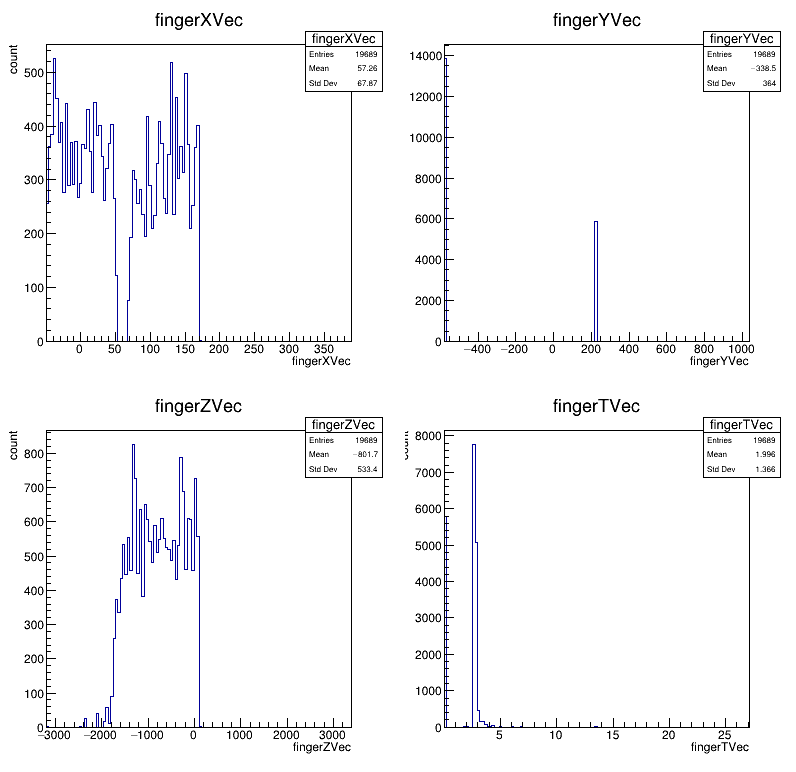

In [5]:
# Canvas 1

hFingerX = fdft.Histo1D('fingerXVec')
hFingerY = fdft.Histo1D('fingerYVec')
hFingerZ = fdft.Histo1D('fingerZVec')
hFingerT = fdft.Histo1D('fingerTVec')

c1 = root.TCanvas("c1","c1",800,800)
c1.Divide(2,2,0.01,0.01,0)

c1.cd(1)
hFingerX.Draw()
c1.cd(2)
hFingerY.Draw()
c1.cd(3)
hFingerZ.Draw()
c1.cd(4)
hFingerT.Draw()

c1.Draw()
c1.Print("plots/c1RA.pdf");

Info in <TCanvas::Print>: pdf file plots/c2RA.pdf has been created


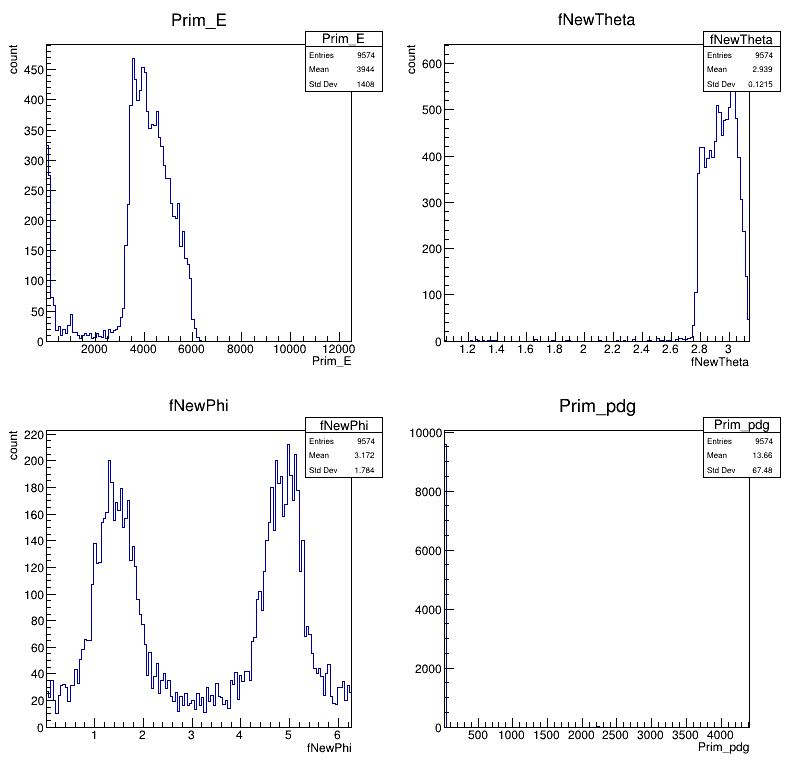

In [6]:
# Canvas 2

hPrimE = fdft.Histo1D('Prim_E')
hPrimTh = fdft.Histo1D('fNewTheta')
hPrimPh = fdft.Histo1D('fNewPhi')
hPrimPdg = fdft.Histo1D('Prim_pdg')

c2 = root.TCanvas("c2","c2",800,800)
c2.Divide(2,2,0.01,0.01,0)

c2.cd(1)
hPrimE.Draw()
c2.cd(2)
hPrimTh.Draw()
c2.cd(3)
hPrimPh.Draw()
c2.cd(4)
hPrimPdg.Draw()

c2.Draw()
c2.Print("plots/c2RA.pdf")


Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Info in <TCanvas::Print>: pdf file plots/c3RA.pdf has been created
Error in <TPad::Range

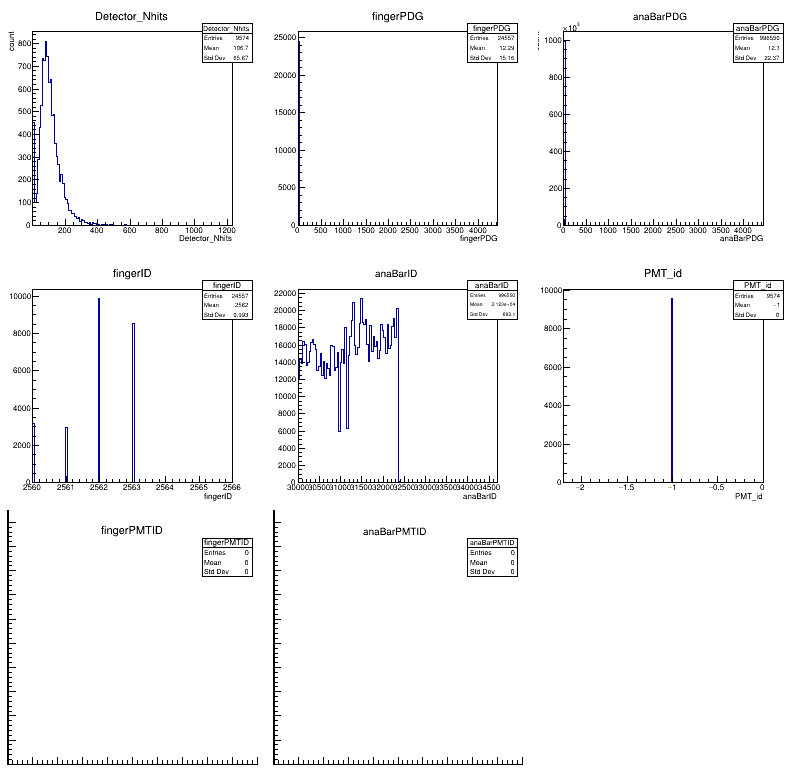

In [7]:
# Canvas 3

hDetectorNhits = fdft.Histo1D('Detector_Nhits')
hDetectorPdg = fdft.Histo1D('anaBarPDG')
hDetectorID = fdft.Histo1D('anaBarID')
hFingerPdg = fdft.Histo1D('fingerPDG')
hFingerID = fdft.Histo1D('fingerID')
hPMTID = fdft.Histo1D('PMT_id')
hAnaBarPMTID = fdft.Histo1D('anaBarPMTID')
hFingerPMTID = fdft.Histo1D('fingerPMTID')

c3 = root.TCanvas("c3","c3",800,800)
c3.Divide(3,3,0.01,0.01,0)

c3.cd(1)
hDetectorNhits.Draw()
c3.cd(2)
hFingerPdg.Draw()
c3.cd(3)
hDetectorPdg.Draw()
c3.cd(4)
hFingerID.Draw()
c3.cd(5)
hDetectorID.Draw()
c3.cd(6)
##hPMTID.GetXaxis().SetRangeUser(0,14)
hPMTID.Draw()
c3.cd(7)
hFingerPMTID.Draw()
c3.cd(8)
hAnaBarPMTID.Draw()

c3.Draw()
c3.Print("plots/c3RA.pdf")


Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000
Info in <TCanvas::Print>: pdf file plots/c4RA.pdf has been created
Error in <TPad::Range>: illegal world coordinates range: x1=0.000000, y1=-0.131250, x2=0.000000, y2=1.181250
Error in <TPad::RangeAxis>: illegal axis coordinates range: xmin=0.000000, ymin=0.000000, xmax=0.000000, ymax=1.050000


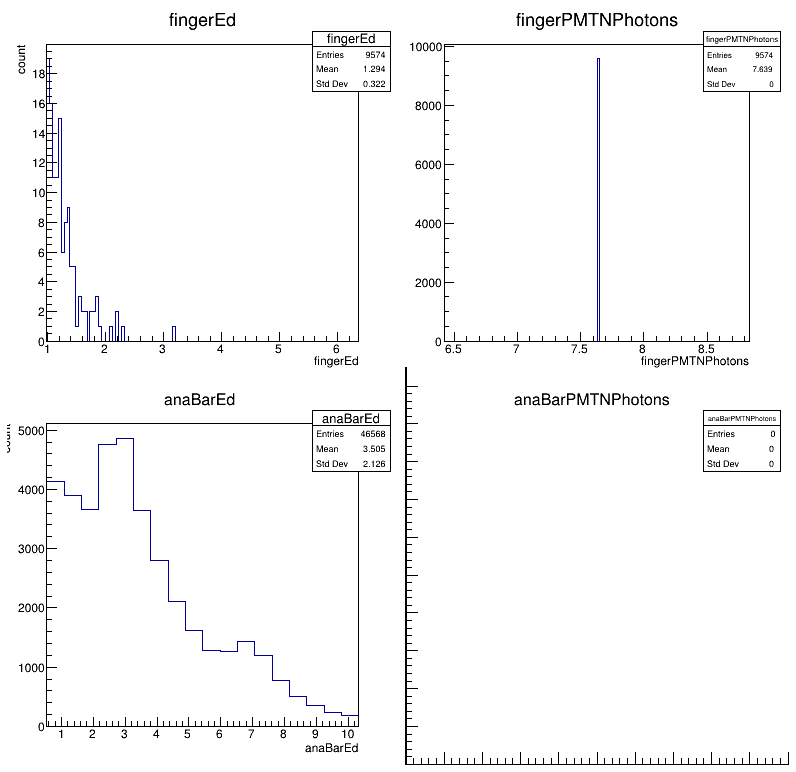

In [8]:
# Canvas 4

hFingerEd = fdft.Histo1D('fingerEd')
hFingerPMTNphot = fdft.Histo1D('fingerPMTNPhotons')
hAnaBarPMTNphot = fdft.Histo1D('anaBarPMTNPhotons')
hAnaBarEd = fdft.Histo1D('anaBarEd')

c4 = root.TCanvas("c4","c4",800,800)

c4.cd()
pad = root.TPad("pad","pad",0.01,0.51,0.50,0.99)
pad.Draw()
pad.cd()
hFingerEd.GetXaxis().SetRangeUser(1.0,10)
hFingerEd.Draw();

c4.cd()
pad = root.TPad("pad","pad",0.51,0.51,0.99,0.99)
pad.Draw()
pad.cd()
hFingerPMTNphot.GetXaxis().SetRangeUser(-10,250)
hFingerPMTNphot.Draw()

c4.cd()
pad = root.TPad("pad","pad",0.01,0.01,0.50,0.50)
#pad.SetLogy()
pad.Draw()
pad.cd()
hAnaBarEd.GetXaxis().SetRangeUser(1.0,10)
hAnaBarEd.Draw();

c4.cd()
pad = root.TPad("pad","pad",0.51,0.01,0.99,0.50)
#pad.SetLogy()
pad.Draw()
pad.cd()
hAnaBarPMTNphot.GetXaxis().SetRangeUser(-20,180)
hAnaBarPMTNphot.Draw()

c4.Draw()
c4.Print("plots/c4RA.pdf")

Info in <TCanvas::Print>: pdf file plots/c5RA.pdf has been created


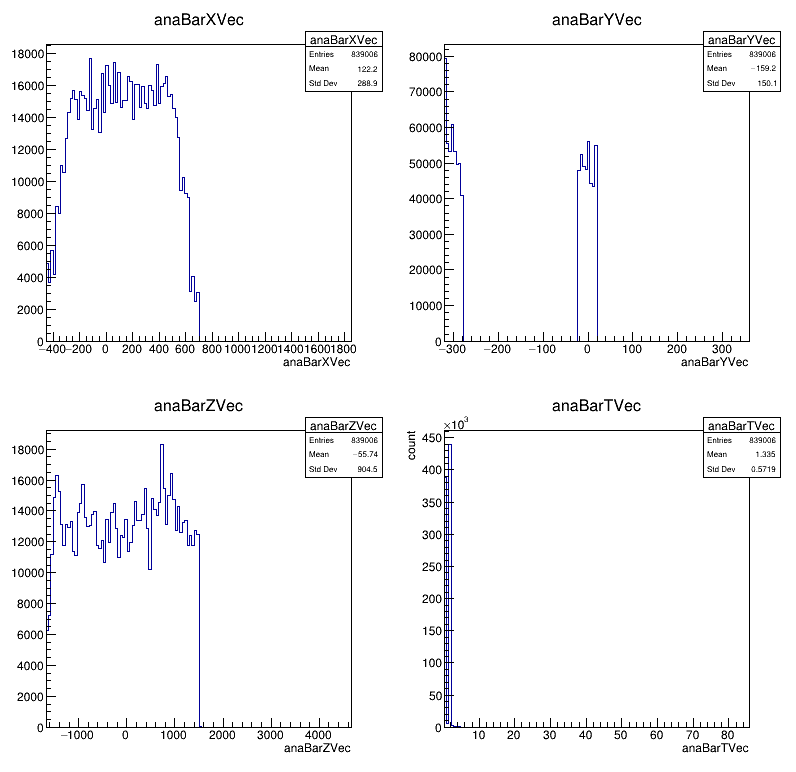

In [9]:
# Canvas 5

hAnaBarX = fdft.Histo1D('anaBarXVec')
hAnaBarY = fdft.Histo1D('anaBarYVec')
hAnaBarZ = fdft.Histo1D('anaBarZVec')
hAnaBarT = fdft.Histo1D('anaBarTVec')

c5 = root.TCanvas("c5","c5",800,800)
c5.Divide(2,2,0.01,0.01,0)

c5.cd(1)
hAnaBarX.Draw()
c5.cd(2)
hAnaBarY.Draw()
c5.cd(3)
hAnaBarZ.Draw()
c5.cd(4)
hAnaBarT.Draw()

c5.Draw()
c5.Print("plots/c5RA.pdf");

Info in <TCanvas::Print>: pdf file plots/c6RA.pdf has been created


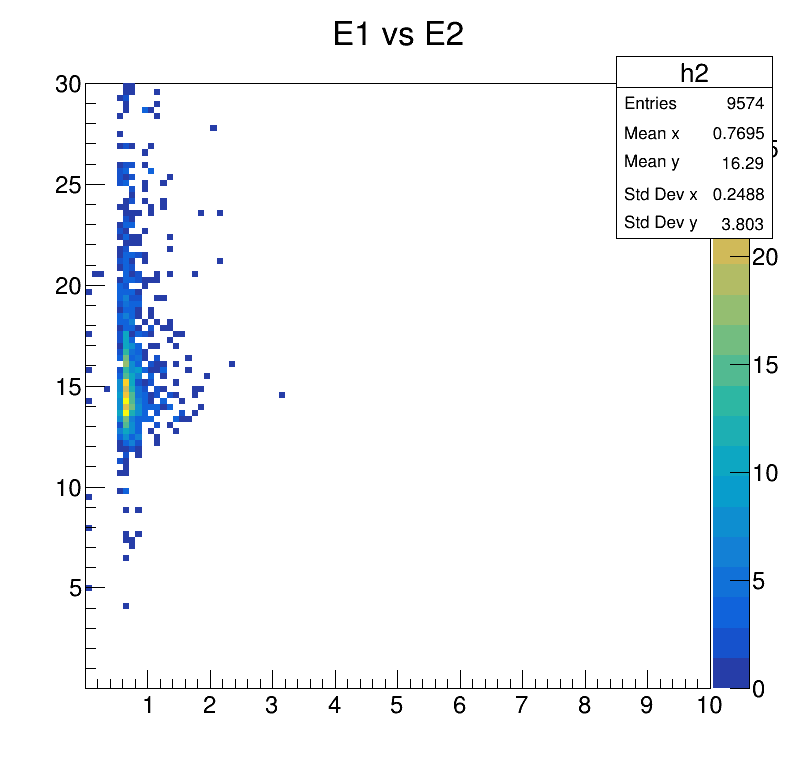

In [10]:
hE1vsE2 = fdft.Histo2D(("h2", "E1 vs E2", 100, 0.01, 10.0, 100, 0.01, 30.0),"fingerEd","anaBarEdTotal")

c6 = root.TCanvas("c6", "c6", 800, 800)
c6.Divide(1,1, 0.01, 0.01, 0)

c6.cd(1)
hE1vsE2.Draw("COLZ")

c6.Draw()
c6.Print("plots/c6RA.pdf")

In [11]:
hFinger_Edep_vs_Nphot = fdft.Filter("trigger2").Histo2D(("h3", "Finger Edep vs Nphot", 100, 0.01, 500.0, 100, 0.01, 10.0),"fingerPMTNPhotons","fingerEd")
hAnaBar_Edep_vs_Nphot = fdft.Filter("trigger2").Histo2D(("h4", "AnaBar Edep vs NphotTotal", 100, 0.01, 30.0, 100, 0.01, 500.0),"anaBarEdTotal","anaBarNPhotonsTotal")
hNphot0_vs_Nphot1 = fdft.Filter("trigger2").Histo2D(("h5", "AnaBar NphotTotal vs Finger Nphot", 100, 0.01, 500.0, 100, 0.01, 500.0),"anaBarNPhotonsTotal","fingerPMTNPhotons")

c7 = root.TCanvas("c7", "c7", 800, 800)
c7.Divide(2,2, 0.01, 0.01, 0)

#c7PE_MeV = root.TCanvas("c7PE_MeV", "c7PE_MeV", 800,800)
#c7Profile = root.TCanvas("c7Profile", "c7Profile", 800,800)

c7.cd(1)
hFinger_Edep_vs_Nphot.Draw("COLZ")
c7.cd(2)
hAnaBar_Edep_vs_Nphot.Draw("COLZ")
c7.cd(3)
hNphot0_vs_Nphot1.Draw("COLZ")
c7.cd(4)
prof = hAnaBar_Edep_vs_Nphot.ProfileX()
prof.Fit("pol1")

Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option

Info in <TCanvas::Print>: pdf file plots/c7RA.pdf has been created


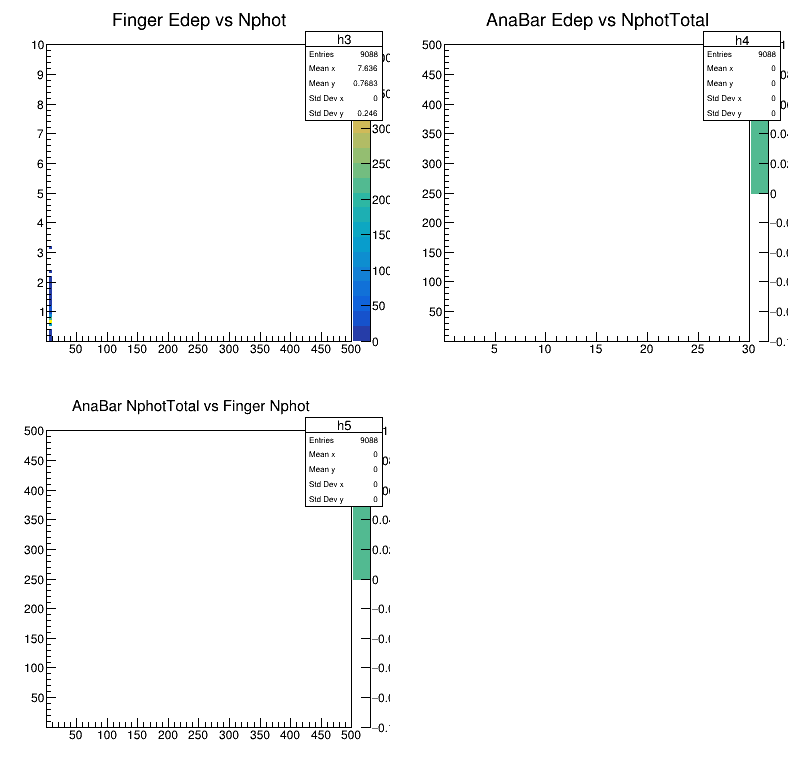

In [12]:
c7.Draw()
c7.Print("plots/c7RA.pdf")

In [13]:
hFinger_Edep_vs_NphotCut = fdft.Filter("trigger3").Histo2D(("h3", "Finger Edep vs Nphot", 100, 0.01, 500.0, 100, 0.01, 10.0),"fingerPMTNPhotons","fingerEd")
hAnaBar_Edep_vs_NphotCut = fdft.Filter("trigger3").Histo2D(("h4", "AnaBar Edep vs Nphot", 100, 0.01, 30.0, 100, 0.01, 500.0),"anaBarEdTotal","anaBarNPhotonsTotal")
hNphot0_vs_Nphot1Cut = fdft.Filter("trigger3").Histo2D(("h5", "AnaBar Nphot vs Finger Nphot", 100, 0.01, 500.0, 100, 0.01, 500.0),"anaBarNPhotonsTotal","fingerPMTNPhotons")

c8 = root.TCanvas("c8", "c8", 800, 800)
c8.Divide(2,2, 0.01, 0.01, 0)

#c7PE_MeV = root.TCanvas("c7PE_MeV", "c7PE_MeV", 800,800)
#c7Profile = root.TCanvas("c7Profile", "c7Profile", 800,800)

c8.cd(1)
hFinger_Edep_vs_NphotCut.Draw("COLZ")
c8.cd(2)
hAnaBar_Edep_vs_NphotCut.Draw("COLZ")
c8.cd(3)
hNphot0_vs_Nphot1Cut.Draw("COLZ")
c8.cd(4)
prof = hAnaBar_Edep_vs_NphotCut.ProfileX()
prof.Fit("pol1")

Warning in <Fit>: Fit data is empty 
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option S
Error in <TFitResultPtr>: TFitResult is empty - use the fit option

Info in <TCanvas::Print>: pdf file plots/c8RA.pdf has been created


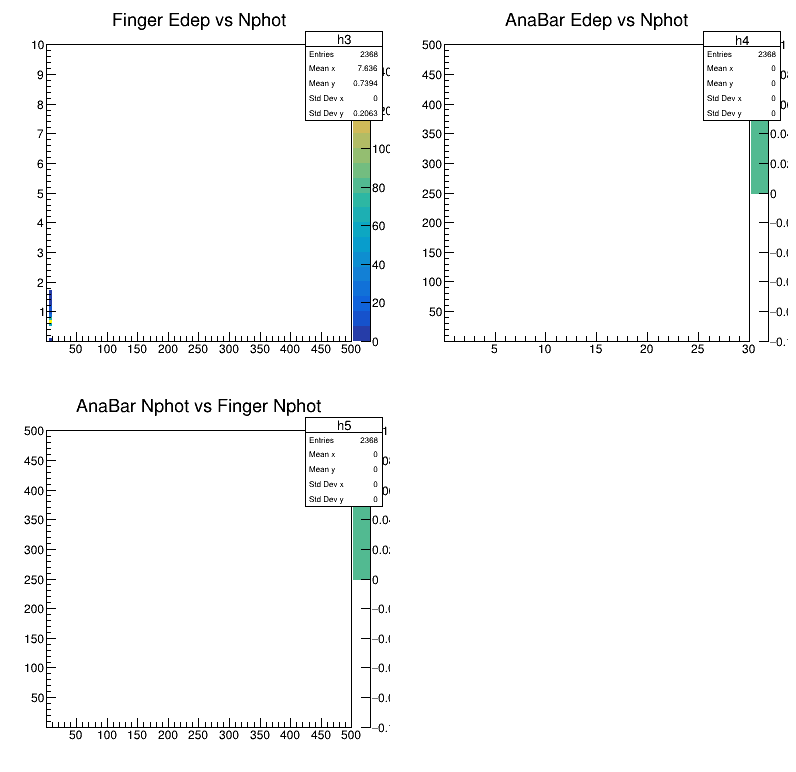

In [14]:
c8.Draw()
c8.Print("plots/c8RA.pdf")

In [15]:
#NUMPADDLE=14
#
#hAnaBarEdAll = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarEd%d" % i)
#    title = ("AnaBar Energy Deposited A%d" % i)
#    name2 = ("anaBarEd[%d]" %i)
#    hAnaBarEdAll.append(fdft.Define(name,name2).Filter("trigger3").Histo1D((name, title, 100, 0.01, 10.0),name))
#    
#hAnaBarEdAllCut = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarEd%dCut" % i)
#    title = ("AnaBar Energy Deposited A%d" % i)
#    name2 = ("anaBarEd[%d]" %i)
#    name3 = ("trigger3 && anaBarPMTNPhotons[%d]>100.0" % i)
#    hAnaBarEdAllCut.append(fdft.Define(name,name2).Filter(name3).Histo1D((name, title, 100, 0.01, 10.0),name))
#
#cEd = root.TCanvas("cEd", "cEd", 800,800)
#cEd.Divide(4,4)
#
#means = []
#meanErr = []
#
#start = 5.5
#gf = root.TF1("gf", "gaus", start, 10.0)
#
#for i in range(NUMPADDLE):
#    
#    print ("Paddle = ",i+1)
#
#    cEd.cd(i+1)
#    
#    hAnaBarEdAll[i].Draw()
#    hAnaBarEdAllCut[i].SetLineColor(2)
#    hAnaBarEdAllCut[i].Draw("SAME")
#    
#cEd.Draw()
#cEd.Print("plots/cEdRA.pdf")

In [16]:
#hAnaBarPMTNphotArray = []
#
#for i in range(NUMPADDLE):  
#    name = ("AnaBarPMTNphotA%d" % i)
#    title = ("AnaBar_PMT_Number_of_Photons_A%d" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    hAnaBarPMTNphotArray.append(fdft.Define(name,name2).Filter("trigger").Histo1D((name, title, 200, -20, 180.0),name))
#    
#hAnaBarPMTNphotCut = []
#    
#for i in range(NUMPADDLE):  
#    name = ("AnaBarPMTNphotA%dCut" % i)
#    title = ("AnaBar_PMT_Number_of_Photons_A%d_Cut" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    hAnaBarPMTNphotCut.append(fdft.Define(name,name2).Filter("trigger3").Histo1D((name, title, 200, -20, 180.0),name))
#    
#hAnaBarPMTNoiseCutNphot = []
#
#for i in range(NUMPADDLE):
#    name = ("AnaBarPMTNoiseCutNphotA%d" % i)
#    title = ("AnaBar PMT Number of Photons A%d" % i)
#    name2 = ("anaBarPMTNPhotons[%d]" % i)
#    name3 = ("trigger3 && anaBarEd[%d]>4.0" % i)
#    hAnaBarPMTNoiseCutNphot.append(fdft.Define(name,name2).Filter(name3).Histo1D((name, title, 200, -20, 180.0),name))
#
#c9 = root.TCanvas("c9", "c9", 800,800)
#
#print("Fitting ...\n")
#fr = [float, float]
#fp, fpe = [float, float, float, float], [float, float, float, float]
#pllo = [0.05, 0.5, 1.0, 0.04]
#plhi = [10.0, 50.0, 10000.0, 5.0]
#sv = [1.8, 5.0, 1400.0, 3.0]
#chisqr = float
#ndf = int
#SNRPeak, SNRFWHM = float, float
#
#
#for i in range(NUMPADDLE):
#        c9.cd()
#        xl = 0.25*(i%4)
#        xh = 0.25*(i%4)+0.25
#        yl = 0.75 - 0.25*int(i/4)
#        yh = 0.75 - 0.25*int(i/4) + 0.25
#        #print (i,xl,yl,xh,yh)
#        pad = root.TPad("pad","pad",xl,yl,xh,yh)
#        pad.SetLogy(True)
#        pad.Draw()
#        pad.cd()
#        hAnaBarPMTNphotArray[i].Draw()
#        hAnaBarPMTNoiseCutNphot[i].SetLineColor(2)
#        hAnaBarPMTNoiseCutNphot[i].Draw("SAME")
#        #hAnaBarPMTNoiseCutNphot[i].Fit("gaus")

In [17]:
#c9.Draw()
#c9.Print("plots/c9RA.pdf")

Info in <TCanvas::Print>: pdf file plots/c11RA.pdf has been created


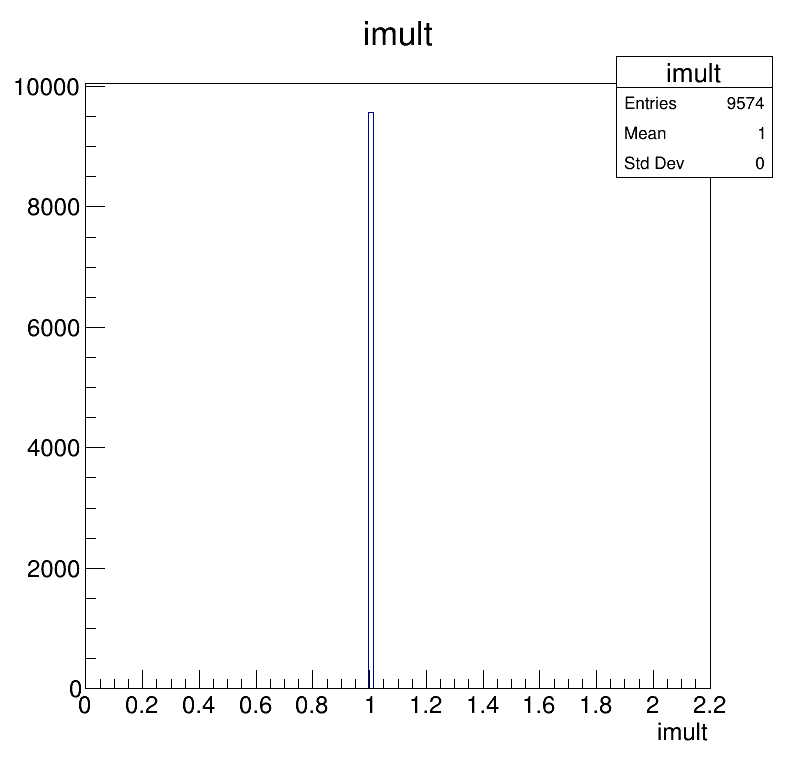

In [18]:
hAnaBarMult = fdft.Histo1D("imult")

c11 = root.TCanvas("c11", "c11", 800,800)
c11.Divide(1,1, 0.01, 0.01, 0)

c11.cd(1)
hAnaBarMult.Draw()

c11.Draw()
c11.Print("plots/c11RA.pdf")

Info in <TCanvas::Print>: pdf file plots/c12RA.pdf has been created


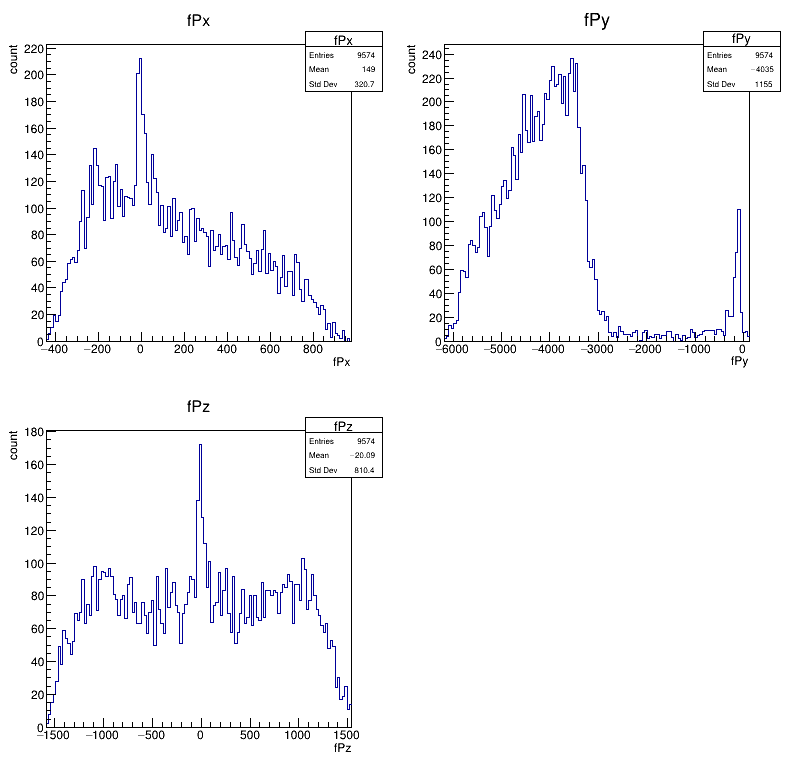

In [19]:
hPrimPx = fdft.Histo1D("fPx")
hPrimPy = fdft.Histo1D("fPy")
hPrimPz = fdft.Histo1D("fPz")

c12 = root.TCanvas("c12", "c12", 800,800)
c12.Divide(2,2, 0.01, 0.01, 0)

c12.cd(1)
hPrimPx.Draw()
c12.cd(2)
hPrimPy.Draw()
c12.cd(3)
hPrimPz.Draw()

c12.Draw()
c12.Print("plots/c12RA.pdf")

In [20]:
t.stop()

Elapsed time: 30.1005 seconds


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c13


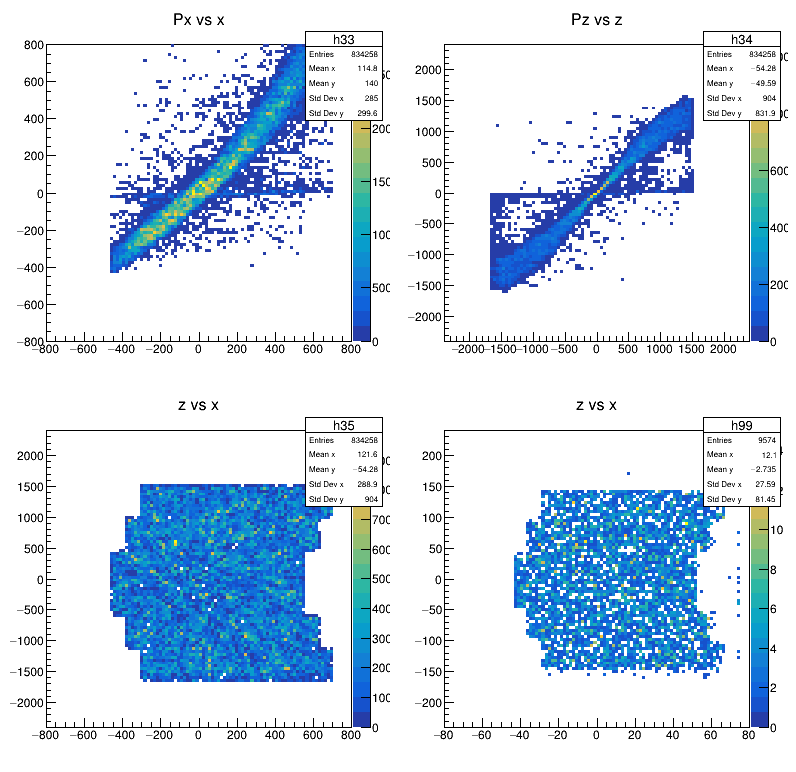

In [24]:
hPx_vs_x = fdft.Filter("trigger2").Histo2D(("h33", "Px vs x", 100, -800.0, 800.0, 100, -800.0, 800.0),"anaBarXVec","fPx")
hPz_vs_z = fdft.Filter("trigger2").Histo2D(("h34", "Pz vs z", 100, -2400.0, 2400.0, 100, -2400.0, 2400.0),"anaBarZVec","fPz")
hz_vs_x = fdft.Filter("trigger2").Histo2D(("h35", "z vs x", 100, -800.0, 800.0, 100, -2400.0, 2400.0),"anaBarXVec","anaBarZVec")
hPrimXZ = fdft.Histo2D(("h99", "z vs x", 100, -80.0, 80.0, 100, -240.0, 240.0),"Prim_X","Prim_Z")

c13 = root.TCanvas("c13", "c13", 800, 800)
c13.Divide(2,2, 0.01, 0.01, 0)

c13.cd(1)
hPx_vs_x.Draw("COLZ")
c13.cd(2)
hPz_vs_z.Draw("COLZ")
c13.cd(3)
hz_vs_x.Draw("COLZ")
c13.cd(4)
hPrimXZ.Draw('COLZ')

c13.Draw()

Info in <TCanvas::Print>: pdf file plots/c14RA.pdf has been created


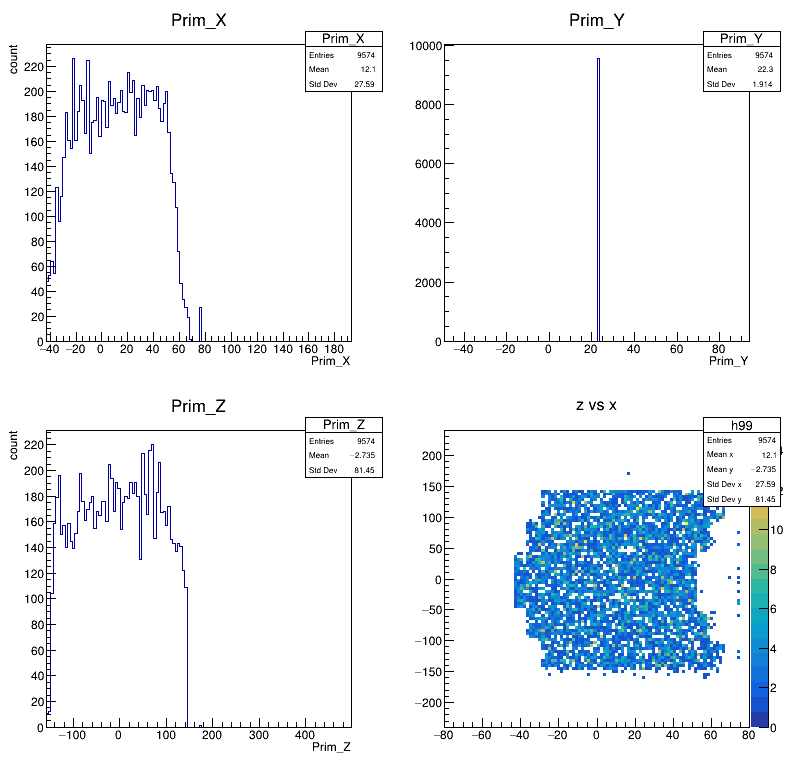

In [22]:
# Canvas 14

hPrimX = fdft.Histo1D('Prim_X')
hPrimY = fdft.Histo1D('Prim_Y')
hPrimZ = fdft.Histo1D('Prim_Z')
hPrimXZ = fdft.Histo2D(("h99", "z vs x", 100, -80.0, 80.0, 100, -240.0, 240.0),"Prim_X","Prim_Z")

c14 = root.TCanvas("c14","c14",800,800)
c14.Divide(2,2,0.01,0.01,0)

c14.cd(1)
hPrimX.Draw()
c14.cd(2)
hPrimY.Draw()
c14.cd(3)
hPrimZ.Draw()
c14.cd(4)
hPrimXZ.Draw('COLZ')

c14.Draw()
c14.Print("plots/c14RA.pdf")